<a href="https://colab.research.google.com/github/ArtAnichkin/msuai-hw/blob/main/EX03_Classic_ML_%D0%90%D0%BD%D0%B8%D1%87%D0%BA%D0%B8%D0%BD_%D0%90%D1%80%D1%82%D0%B5%D0%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 1. Bootstrap

В этом задании используйте датасет breast_cancer — классический датасет для задачи бинарной классификации. Обучите модели:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LigthGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`.

Параметры моделей можете оставить по умолчанию или задать сами.

Для каждой модели посчитайте [корреляцию Мэтьюса](https://en.wikipedia.org/wiki/Phi_coefficient) — метрику для оценки качества бинарной классификации, в частности, устойчивую к дисбалансу классов, ([`sklearn.metrics.matthews_corrcoef`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), подробнее почитать про его пользу можно [здесь](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7)) — для предсказанного ею класса и реального.

С помощью bootstrap-подхода постройте 90% доверительные интервалы для качества полученных моделей. Используйте функцию `bootstrap_metric()` из лекции.

Постройте [боксплоты](https://seaborn.pydata.org/generated/seaborn.boxplot.html) для качества полученных моделей.

Импорт необходимых библиотек:

In [ ]:
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

Загрузка датасета:

In [ ]:
breast_cancer = sklearn.datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [ ]:
x = breast_cancer.data
y = breast_cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [ ]:
# Your code here

In [ ]:
models = [DecisionTreeClassifier(), RandomForestClassifier(), lightgbm.LGBMClassifier(n_estimators=100), SVC(), BaggingClassifier()]

In [ ]:
preds = []
mat_metric = []
for model in models:
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mat_metric.append(matthews_corrcoef(y_pred, y_test))
    preds.append(y_pred)


[LightGBM] [Info] Number of positive: 268, number of negative: 158
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4272
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.629108 -> initscore=0.528392
[LightGBM] [Info] Start training from score 0.528392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [ ]:
print(*zip(models,mat_metric), sep='\n')

(DecisionTreeClassifier(), 0.8822275826137275)
(RandomForestClassifier(), 0.940477037066757)
(LGBMClassifier(), 0.8963356530877563)
(SVC(), 0.8965050191922527)
(BaggingClassifier(), 0.9107365792759051)


In [ ]:
def bootstrap_metric(x, y, metric_fn, samples_cnt=1000, random_state=42):
    np.random.seed(random_state)
    b_metric = np.zeros(samples_cnt)
    for it in range(samples_cnt):
        poses = np.random.choice(x.shape[0], size=x.shape[0], replace=True)

        x_boot = x[poses]
        y_boot = y[poses]
        m_val = metric_fn(x_boot, y_boot)
        b_metric[it] = m_val

    return b_metric

mat score for the DecisionTreeClassifier():  [0.79804394 0.9562213 ]
mat score for the RandomForestClassifier():  [0.88050459 0.98577827]
mat score for the LGBMClassifier():  [0.82034428 0.95746683]
mat score for the SVC():  [0.81701392 0.96896539]
mat score for the BaggingClassifier():  [0.83813536 0.97140837]


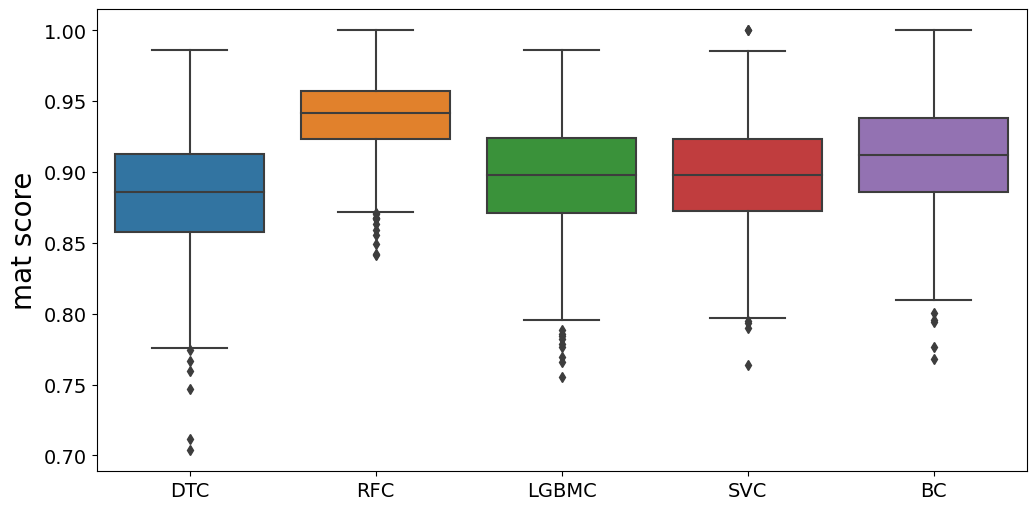

In [ ]:
alpha = 0.05
boot_score = []
for model, pred in zip(models, preds):
    boot_mat = bootstrap_metric(
        y_test, pred, metric_fn=lambda x, y: matthews_corrcoef(y_true=x, y_pred=y)
    )
    boot_score.append(boot_mat)

    print(
        f"mat score for the {model}: ",
        np.quantile(boot_mat, q=[alpha / 2, 1 - alpha / 2]),
    )

plt.figure(figsize=(12, 6))
sns.boxplot(
    y=np.concatenate(boot_score),
    x=["DTC"] * 1000 + ["RFC"] * 1000 + ["LGBMC"] * 1000 + ["SVC"] * 1000 + ["BC"] * 1000,
)
plt.ylabel("mat score", size=20)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.show()

Сделайте вывод о том, какие модели работают лучше.

**Напишите вывод**

Наилучшим образом себя показывает RFC судя по среднему метрике корреляции Мэтьюса. Также процентиль выше всех остальных, поэтому модель даже стабильнее остальных

## Формат результата

График с демонстрацией корреляции Мэтьюса для следующих моделей:

 - `DecisionTreeClassifier`
 - `RandomForestClassifier`
 - `LigthGBMClassifier`
 - `SVC`
 - `BaggingClassifier` с базовым класификатором `SVC`

Пример графика:

<img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/Exercises/EX03/result_1_task_ex03.png" width="600">

# Задание 2. Дисбаланс классов

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -qU imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 2.7 MB/s eta 0:00:00


In [ ]:
import imblearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedKFold,
    cross_validate,
)

Важно обращать внимание на сбалансированность классов в наборе.
Предположим, у нас есть некоторый набор данных со следующими метками классов:

In [ ]:
real_labels = [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]

В наборе 16 объектов относятся к классу 0, а 5 — к классу 1.

Мы обучили две модели. Первая всегда выдает 0:

In [ ]:
model1_res = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Вторая сумела обнаружить некоторую закономерность в признаках:

In [ ]:
model2_res = [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1]

Рассчитаем точность Accuracy (см. лекцию 1) для этих моделей:

In [ ]:
print("Accuracy for model1: ", accuracy_score(real_labels, model1_res))
print("Accuracy for model2: ", accuracy_score(real_labels, model2_res))

Accuracy for model1:  0.7619047619047619
Accuracy for model2:  0.7619047619047619


Accuracy нельзя использовать, если данные не сбалансированы. Для несбалансированных данных необходимо использовать свои метрики и модели. Одной из таких метрик является balanced accuracy. При вычислении данной метрики считается полнота (recall) отдельно для каждого класса и вычисляется среднее значение:

In [ ]:
# Balanced accuracy for model1 = (16/16+0/5)/2 = 0.5
print(
    "Balanced accuracy for model1: ", balanced_accuracy_score(real_labels, model1_res)
)
# Balanced accuracy for model2 = (12/16+4/5)/2 = 0.775
print(
    "Balanced accuracy for model2: ", balanced_accuracy_score(real_labels, model2_res)
)

Balanced accuracy for model1:  0.5
Balanced accuracy for model2:  0.775


**Всегда проверяйте**, являются ли ваши данные сбалансированными и могут ли выбранные для оценки модели метрики работать с несбалансированными классами.

Загрузим датасет с различными биомаркерами пациентов с меланомой (обезличенный, информации о пациентах нет) и переменной, содержащей 1, если пациент ответил на иммунотерапию (терапия помогла пациенту и произошло уменьшение размеров опухоли), и 0, если не ответил. Количество пациентов, отвечающих на терапию, сильно меньше пациентов, которым терапия не помогает, поэтому предсказание ответа пациента на терапию на основании биомаркеров — актуальная задача в онкологии. В данном задании вам предстоит попробовать её решить.

In [ ]:
cancer = pd.read_table(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/Cancer_dataset_2.tsv",
    index_col="sample_id",
)
display(cancer.head())

# split the data on features (x) and dependant variable (y)
y = cancer["Response"]
x = cancer.drop("Response", axis=1)
print("\nNumber of patients responded to immunotherapy:")
display(y.value_counts())

,IgG1/IgA,IL21,CXCL9,CXCL10,CD8A,GZMB,KLRC2,KLRC3,KLRC4,GNLY,TGFB1,Response
sample_id,,,,,,,,,,,,
SAM4b0175e8db6e,3.242746,0.001280,-0.002986,-0.036366,0.096658,0.063467,0.502058,-0.083862,0.053659,0.091930,61.934119,0
SAMd215b503f99a,2.139016,-0.000089,0.030495,0.243958,0.161128,0.565798,-0.203495,-0.026902,-0.035405,0.030125,103.265837,0
SAM7fb6987514a4,12.614972,0.008103,0.502043,0.530783,0.388455,0.528142,-0.156209,0.001147,-0.028690,0.260703,53.552817,0
SAMd636e3461955,6.365973,-0.000139,0.024035,0.115127,0.084455,0.200038,-0.387373,-0.057837,0.045938,0.073192,80.837318,0
SAMc0da5d48686d,2.764089,0.006107,0.015533,0.135470,0.067686,0.053499,-0.116040,0.063714,0.088201,0.082940,114.422926,0



Number of patients responded to immunotherapy:


0    228
1     37
Name: Response, dtype: int64

В данном случае имеет место несбалансированность классов в наборе данных: пациентов, ответивших на терапию, гораздо меньше.

Есть два способа работы с несбалансированными по классам данными. Первый способ &mdash; это получение стратифицированных выборок. Необходимо иметь одинаковую долю образцов каждого класса в тренировочной и тестовой выборках, иначе возникает риск получения смещённых выборок, что приводит к некорректной оценке качества модели. Второй способ &mdash; это использование специальных алгоритмов, учитывающих несбалансированность классов.


В данном задании вам нужно продемонстрировать эффективность различных подходов  работы с несбалансированными выборками. Для этого вы будете использовать три модели, представленные ниже:

1. [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn
2. [`RandomForestClassifier` с балансировкой классов](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html), библиотека sklearn — меняет стандартный вес каждого класса, равный 1, на долю класса во входных данных (см. `class_weight`).
3. [`BalancedRandomForestClassifier`](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html), библиотека imblearn — сэмплирует псевдовыборки таким образом, что в каждой псевдовыборке, которая подается на вход модели, баланс классов оказывается "выправлен".

Оцените эффективность подходов с помощью кросс-валидации, производя разбиение с учетом репрезентации классов и без него. В качестве метрики, отображающей эффективность модели, используйте значения `accuracy` и `balanced_accuracy`. Проинтерпретируйте результаты.

In [ ]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

models = [RandomForestClassifier(), RandomForestClassifier(class_weight='balanced'), imblearn.ensemble.BalancedRandomForestClassifier()]
scores = pd.DataFrame(columns=models)

for model in models:
    cv_kf = cross_validate(model, x, y, cv=KFold(n_splits=5, shuffle=True), scoring=['accuracy', 'balanced_accuracy'])
    cv_skf = cross_validate(model, x, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring=['accuracy', 'balanced_accuracy'])
    print(f'''{model}, kf:
        accuracy = {np.array(cv_kf['test_accuracy']).mean()}
        accuracy_bal {np.array(cv_kf['test_balanced_accuracy']).mean()}''')
    print(f'''{model}, skf:
        accuracy = {np.array(cv_skf['test_accuracy']).mean()}
        accuracy_bal {np.array(cv_skf['test_balanced_accuracy']).mean()}
          ''')

RandomForestClassifier(), kf:
        accuracy = 0.8528301886792453
        accuracy_bal 0.5351861764602981
RandomForestClassifier(), skf:
        accuracy = 0.8679245283018868
        accuracy_bal 0.559404761904762
          
RandomForestClassifier(class_weight='balanced'), kf:
        accuracy = 0.8603773584905661
        accuracy_bal 0.5291666666666667
RandomForestClassifier(class_weight='balanced'), skf:
        accuracy = 0.8641509433962264
        accuracy_bal 0.5451673567977916
          
BalancedRandomForestClassifier(), kf:
        accuracy = 0.660377358490566
        accuracy_bal 0.6696548409961915
BalancedRandomForestClassifier(), skf:
        accuracy = 0.6867924528301886
        accuracy_bal 0.6922222222222223
          


In [ ]:
from sklearn.dummy import DummyClassifier
cv_dum = cross_validate(DummyClassifier(), x, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring=['accuracy', 'balanced_accuracy'])

print(f'''dummie, skf:
    accuracy = {np.array(cv_dum['test_accuracy']).mean()}
    accuracy_bal {np.array(cv_dum['test_balanced_accuracy']).mean()}
      ''')

dummie, skf:
    accuracy = 0.8603773584905661
    accuracy_bal 0.5
      


Объекты, принадлежащие разным классам, распределены неравномерно. Для адекватной работы cross_validate нужно перемешать данные. Для этого используйте флаг `shuffle=True`, применяя `KFold` и `StratifiedKFold` (см. параметр `cv` в функции cross_validate).

In [ ]:
# Your code here

Какая модель лучше справляется с дисбалансом классов?

**Напишите вывод**

Наилучшей себя показала модель BalancedRandomForestClassifier судя по метрике accuracy_bal, также она показала себя гораздо лучше чем случайная модель. Стартификация помогла немного, но скор сильно не улучшился на этой модели, зато на невзвешенном лесе все стало немного получше

## Формат результата

Получить значения `accuracy` и `balanced_accuracy`для моделей:
1. `RandomForestClassifier`, библиотека sklearn;
2. `RandomForestClassifier с балансировкой классов`, библиотека sklearn;
3. `BalancedRandomForestClassifier`, библиотека imblearn.


# Задание 3. Разные типы бустингов

В этом задании будем использовать датасет с рейтингом блюд по некоторым характеристикам.

В некоторых реализациях градиентного бустинга есть возможность использовать другой метод обучения. Например, в XGB есть тип `dart`, а в lgbm — `goss`. Это позволяет составлять более эффективные ансамбли.

Используя кросс-валидацию (используйте 3 фолда), обучите модели:
* CatboostRegressor
* XGBRegressor
* LGBMRegressor

Сохраните модель на каждом фолде и посчитайте `mse` для тестовой выборки, используя модель с каждого фолда. Получите предсказания всех 9 моделей на тестовой выборке и усредните их. Затем посчитайте `mse` для усредненных предсказаний.

Напишите выводы о полученном качестве моделей.

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [ ]:
import xgboost
import catboost
import lightgbm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [ ]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)
recipies

,calories,protein,fat,sodium,cakeweek,wasteless,rating
0,426.0,30.0,7.0,559.0,0.0,0.0,2.500
1,403.0,18.0,23.0,1439.0,0.0,0.0,4.375
2,165.0,6.0,7.0,165.0,0.0,0.0,3.750
3,547.0,20.0,32.0,452.0,0.0,0.0,3.125
4,948.0,19.0,79.0,1042.0,0.0,0.0,4.375
...,...,...,...,...,...,...,...
15859,28.0,2.0,2.0,64.0,0.0,0.0,3.125
15860,671.0,22.0,28.0,583.0,0.0,0.0,4.375
15861,563.0,31.0,38.0,652.0,0.0,0.0,4.375
15862,631.0,45.0,24.0,517.0,0.0,0.0,4.375


In [ ]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train_all, x_test, y_train_all, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
cv_cat = cross_validate(catboost.CatBoostRegressor(verbose=0), x_train_all, y_train_all,
                       cv=KFold(n_splits=3, shuffle=True, random_state=42),
                       scoring=['neg_mean_squared_error'], return_estimator=True)

cv_xgb = cross_validate(xgboost.XGBRegressor(booster='dart', rate_drop=0.1, one_drop=1), x_train_all, y_train_all,
                       cv=KFold(n_splits=3, shuffle=True, random_state=42),
                       scoring=['neg_mean_squared_error'], return_estimator=True)

cv_lgbm = cross_validate(lightgbm.LGBMRegressor(data_sample_strategy='goss'), x_train_all, y_train_all,
                       cv=KFold(n_splits=3, shuffle=True, random_state=42),
                       scoring=['neg_mean_squared_error'], return_estimator=True)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 825
[LightGBM] [Info] Number of data points in the train set: 7402, number of used features: 4
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 3.760977
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 908
[LightGBM] [Info] Number of data points in the train set: 7403, number of used features: 4
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 3.758611
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 830
[LightGBM] [Info] Number of data points in the train set: 7403, numbe

In [ ]:
preds_cat = []
mse_list = []
for es in cv_cat['estimator']:
    y_pred = es.predict(x_test)
    preds_cat.append(y_pred)
    mse_list.append(mse(y_test, y_pred))
print('cat_mse:', mse_list)

preds_xgb = []
mse_list = []
for es in cv_xgb['estimator']:
    y_pred = es.predict(x_test)
    preds_xgb.append(y_pred)
    mse_list.append(mse(y_test, y_pred))
print('xgb_mse:', mse_list)

preds_lgbm = []
mse_list = []
for es in cv_lgbm['estimator']:
    y_pred = es.predict(x_test)
    preds_lgbm.append(y_pred)
    mse_list.append(mse(y_test, y_pred))
print('lgbm_mse:', mse_list)

cat_mse: [1.5627819275715273, 1.5667554291281447, 1.5584688013584853]
xgb_mse: [1.5604820064377913, 1.569034575288004, 1.5549035254992096]
lgbm_mse: [1.610493311177405, 1.600718557352586, 1.5992510617506628]


In [ ]:
preds_cat, preds_xgb, preds_lgbm = np.array(preds_cat), np.array(preds_xgb), np.array(preds_lgbm)

mean_preds = np.mean(np.concatenate((preds_cat, preds_xgb, preds_lgbm)), axis=0)

print('mean_model mse:', mse(y_test, mean_preds))

mean_model mse: 1.5236614385287428


MSE на средних от всех моделей предиктах лучше чем на каждой по отдельности, как логично)

## Формат результата

Получить значения MSE для всех моделей и значение MSE, усреднив предсказания всех моделей. Написать вывод.


# Задание 4. Подбор гиперпараметров

В этом задании нужно подобрать параметры для бустинга `CatBoostRegressor`, используя библиотеку `optuna`. И улучшить результат по сравнению со стандартными параметрами.

Список параметров для подбора:

* `depth`
* `iterations`
* `learning_rate`
* `colsample_bylevel`
* `subsample`
* `l2_leaf_reg`
* `min_data_in_leaf`
* `max_bin`
* `random_strength`
* `bootstrap_type`

**Важно!** *Подбирать параметры нужно на валидационной выборке*

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost
!pip install -q optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
import optuna
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from optuna.samplers import RandomSampler
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, KFold

Загрузка датасета:

In [ ]:
recipies = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/recipes.csv"
)

In [ ]:
y = recipies["rating"]
x = recipies.drop(["rating"], axis=1)

x_train, x_test, y_train, y_test = train_test_split(
    x.values, y.values, train_size=0.7, random_state=42
)

In [ ]:
x_train.shape

(11104, 6)

In [ ]:
model = CatBoostRegressor(random_seed=42)

model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=200,
    use_best_model=True,
    plot=False,
    early_stopping_rounds=100,
)

print("\nmse_score before tuning: ", mse(y_test, model.predict(x_test)))

Learning rate set to 0.074308
0:	learn: 1.2817437	test: 1.2774827	best: 1.2774827 (0)	total: 49.8ms	remaining: 49.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.242760353
bestIteration = 44

Shrink model to first 45 iterations.

mse_score before tuning:  1.5444532948674852


In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
def objective(trial):
    depth = trial.suggest_int("depth", 3, 9, step=1)
    iterations = trial.suggest_int("iterations", 100, 2000, step=1)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.01, 1)
    subsample = trial.suggest_float("subsample", 0.6, 1)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 2, 10, step=1)
    min_data_in_leaf = trial.suggest_int("min_data_in_leaf", 6, 14, step=2)
    max_bin = trial.suggest_int("max_bin", 10, 10000)
    random_strength = trial.suggest_float("random_strength", 1, 4)
    bootstrap_type = trial.suggest_categorical("bootstrap_type", ['Bernoulli', 'MVS'])

    # create new model(and all parameters) every iteration
    model = catboost.CatBoostRegressor(
        depth=depth,
        iterations=iterations,
        learning_rate=learning_rate,
        colsample_bylevel=colsample_bylevel,
        subsample=subsample,
        l2_leaf_reg=l2_leaf_reg,
        min_data_in_leaf=min_data_in_leaf,
        max_bin=max_bin,
        random_strength=random_strength,
        bootstrap_type=bootstrap_type,
        random_state=42,
        verbose=0,
    )

    cv = cross_val_score(model, x_train, y_train, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

    return - cv.mean()


# Create "exploration"
study = optuna.create_study(
    direction="minimize", study_name="Optimizer", sampler=RandomSampler(42)
)

study.optimize(
    objective, n_trials=20
)  # The more iterations, the higher the chances of catching the most optimal hyperparameters

[I 2024-04-15 08:09:53,395] A new study created in memory with name: Optimizer
[W 2024-04-15 08:09:53,401] Trial 0 failed with parameters: {'depth': 5, 'iterations': 1907, 'learning_rate': 0.7346740023932911, 'colsample_bylevel': 0.6026718993550663, 'subsample': 0.6624074561769746, 'l2_leaf_reg': 3, 'min_data_in_leaf': 6, 'max_bin': 8663, 'random_strength': 2.8033450352296265, 'bootstrap_type': 'Bernoulli'} because of the following error: NameError("name 'catboost' is not defined").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-8-e073216ba1d8>", line 14, in objective
    model = catboost.CatBoostRegressor(
NameError: name 'catboost' is not defined
[W 2024-04-15 08:09:53,402] Trial 0 failed with value None.


NameError: name 'catboost' is not defined

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
model = CatBoostRegressor(random_seed=42,
                          **{'depth': 5, 'iterations': 641, 'learning_rate': 0.04651807788098747, 'colsample_bylevel': 0.6134686906400979, 'subsample': 0.8010716092915446, 'l2_leaf_reg': 2, 'min_data_in_leaf': 8, 'max_bin': 9084, 'random_strength': 1.7186856720009174, 'bootstrap_type': 'MVS'}
)

model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=0,
    use_best_model=True,
    plot=False,
)

print("\nmse_score after tuning: ", mse(y_test, model.predict(x_test)))


mse_score after tuning:  1.5396682698769868


## Формат результата

Значение `mse` с подобранными параметрами меньше, чем при стандартных параметрах.

Значение mse после тюны лучше на 0.005
ЕЕЕЕЕЕЕЕ


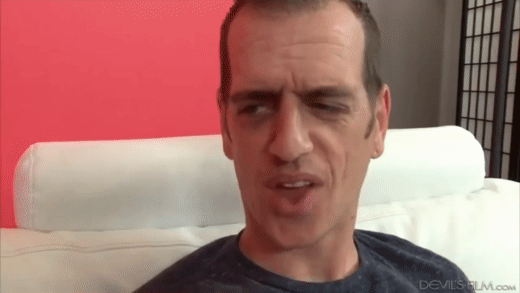

# Задание 5. Ансамблевое обучение (Дополнительно)

В данной задаче вам нужно диагностировать сердечное заболевание у людей по [медицинским показателям](https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci).

Установка и импорт необходимых библиотек:

In [ ]:
!pip install -q catboost
!pip install -q lightgbm==3.0

In [ ]:
import catboost
import lightgbm
import xgboost
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    VotingClassifier,
)

Загрузка датасета:

In [ ]:
heart_dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/heart.csv "
)

In [ ]:
x = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [ ]:
rng = np.random.RandomState(42)

dt = DecisionTreeClassifier(random_state=rng, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=rng)
etc = ExtraTreesClassifier(random_state=rng)
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
svc_lin = SVC(kernel='linear', probability=True, random_state=rng)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=rng)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=42)
lgbm = lightgbm.LGBMClassifier(random_state=42)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", subsample_freq=1,subsample=0.7, random_state=42)
xgb = xgboost.XGBClassifier(random_state=42)
xgb_rf = xgboost.XGBRFClassifier(random_state=42)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

# Your code here

voting_hard =
voting_soft =
# -----------

for model in [voting_hard, voting_soft]:
  scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
  print(f'{model.__class__.__name__}: {scores.mean()}')

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них, не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тренировочном наборе и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Можете модифицировать функцию `base_model_pair_correlation` из лекции.

In [ ]:
# Your code here

Создайте новый ансамбль, на исправленном наборе моделей и оцените его качество с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`.

In [ ]:
# Your code here

voting_hard_2 =
voting_soft_2 =
# ------------

for model in [voting_hard_2, voting_soft_2]:
  scores = cross_val_score(model, x_train, y_train, cv=KFold(n_splits=3, shuffle=True, random_state=rng), scoring='f1')
  print(f'{model.__class__.__name__}: {scores.mean()}')

Обучите все получившиеся модели на тренировочном наборе и испытайте их качество на тестовом наборе. Получилось ли у улучшенных версий ансамблевого классификатора превзойти базовые модели, входящие в него, и свои предыдущие версии?

In [ ]:
# Your code here

Какие ансамбли работают лучше? Всегда ли больше моделей значит лучше?

**Напишите вывод**

## Формат результата

Получить значения качества для ансамблей и моделей.